# Figure 7
The modeling and behavioral experiments in Fig. 5 showed that the timescale of optic flow memory can be shortened by oscillating motion with net-zero displacement.

In this expeirment, we tried to see the neural signature of this memory shortening, focusing on inferior olive. Inferior olive has been shown to contain slow memory like cells, and to be necessary for memory dependent OMR by Yang ... Ahrens (2022).

In [5]:
# packages
from pathlib import Path
import numpy as np
import flammkuchen as fl
from bouter import EmbeddedExperiment
from matplotlib import  pyplot as plt
from scipy.stats import binned_statistic
import colorcet as cc
import json
import re
from scipy.stats import binned_statistic
from homr_util import *
from tqdm import tqdm

In [2]:
# Tweaking matplotlib 
set_rcParams()

### Data loading
- Multiple planes were recorded from a single fish

In [13]:
master_path = Path("./data/fig7")
files = list(master_path.glob('*f*'))
print('Found',len(files),'recordings')

Found 26 recordings


In [14]:
# Find unique fish
fish_name_list = [re.search(r'202\d\d\d\d\d_f\d', f.name)[0] for f in files] # identify fish name by regex
unique_fish_name_list = []
for f in fish_name_list:
    if f not in unique_fish_name_list:
        unique_fish_name_list.append(f)

# nest data paths
nested_list = [[] for i in range(len(unique_fish_name_list))]
for path in files:
    for i, unique_fish_name in enumerate(unique_fish_name_list):
        if unique_fish_name in path.name:
            nested_list[i].append(path)
    
print('Found', len(files), 'recs from', len(unique_fish_name_list), 'fish')
n_rec = len(files)
n_fish = len(unique_fish_name_list)

Found 26 recs from 15 fish


## Data extraction
- Register data in a nested fashion

In [22]:
# nested list
data = [[] for f in unique_fish_name_list]

# loop through recordings
for fid, this_fish_path_list in tqdm(enumerate(nested_list)):
    for path in this_fish_path_list:
        
        # load imaging data
        suite2p_data = fl.load(path / "data_from_suite2p_allrois.h5")
        
        # load time vector
        t_i = fl.load(path / "time.h5")['t']
        
        # load mask
        mask_list = list(path.glob('mask_*'))
        with open(mask_list[-1], 'r') as f:
            mask = json.load(f)

        # get zoom factor
        with open(path / "scandata.json", 'r') as f:
            zoom = json.load(f)['magnification']
            
        # get relevant stuff out
        stack = suite2p_data['anatomy_stack']
        coords = suite2p_data['coords']
        x = coords[:, 2]
        y = coords[:, 1]

        # anatomical pre-selection
        in_mask = (x>mask['x0'])*(x<mask['x1'])*(y>mask['y0'])*(y<mask['y1'])

        traces = suite2p_data['traces'][in_mask, :]
        x = x[in_mask]
        y = y[in_mask]

        # load stimulus sequence
        exp = EmbeddedExperiment(path / 'behavior')
        slog = exp['stimulus']['log']
        
        # register everithing
        D = {'t_i':t_i,
             'mask':mask,
             'stack':stack,
             'traces':traces,
             'x':x,
             'y':y,
             'slog':slog,
             'zoom':zoom}
        data[fid].append(D)  

15it [00:00, 23.17it/s]


## Analysis
### parameters
- each epoch has the following structrue
    - 5 s rest
    - 2 s pre-pulse
    - 6 s wave (optional)
    - 9 s rest

In [23]:
early_onset = 5 # define "early period"  (i.e., during the pulse)
early_offset = 7
late_onset = 13 # time coresponding to after the offset of the wave
late_offset = 22

z_thresh = 2

fr = 5.0 # assumes 5 Hz imaging

### ROI selection and memory activity calculation
- Fish experienced twice more "no wave" epoch iterations than "with wave" epochs
- We split no wave epochs into halves, and use one for memory cell identification, the other for wave effect quantification
    - Cells that showed more than 2 z-score difference by the pulse direction in the "late period" (6~15 s after the pulse offset) qualify as memory cells

In [24]:
# loop through the recordings
for i, fish_data in tqdm(enumerate(data)):
    for j, D in enumerate(fish_data):
        
        # find epoch onsets & categorize them
        slog = D['slog']
        epoch_onsets = [epoch['t_start'] for epoch in slog[1:] if epoch['t_start']]
        epoch_id = np.asarray([int(epoch['vel_pre']<0) + 2*int(epoch['wave_amplitude']>0) for epoch in slog[1:]]) # {no wave, wave} x {forward, backward} (positive velocity is forward)

        # cut trace snip
        snips = cut_triggered_snip(D['traces'], t_i, epoch_onsets, 0, int(slog[1]['duration'] * fr)-1) # roi, time, epochs
        t_snip = np.arange(snips.shape[1]) / fr
        
        # convert to delta f over f
        f0 = np.mean(snips[:, t_snip<=5, :], axis=1)
        dff = (snips - f0[:, None, :]) / f0[:, None, :]
        
        # split epochs according to epoch_id
        orig_inds = [np.where(epoch_id==k)[0] for k in range(4)]
        
        # split no-wave epochs into odd and even, and use only one of them for finding cells 
        inds = (orig_inds[0][0::2], orig_inds[1][0::2], orig_inds[0][1::2], orig_inds[1][1::2], orig_inds[2], orig_inds[3]) 
        
        # sort snip by indices
        sorted_snips = np.asarray([dff[:, :, ind] for ind in inds]) # condition x roi x time x rep 
        
        # Calculate average response within early and late windows (for all epochs) -- condition x roi x rep
        early_activity = np.mean(sorted_snips[:, :, (t_snip>early_onset)*(t_snip<early_offset), :], axis=2)
        late_activity  = np.mean(sorted_snips[:, :, (t_snip>late_onset)*(t_snip<late_offset), :], axis=2)

        # calculate selection criteria on the "training set" (i.e., odd repetitions of the no-wave epoch)
        early_mean_diff = np.mean(early_activity[0, :, :], axis=1) - np.mean(early_activity[1, :, :], axis=1) 
        late_mean_diff  = np.mean(late_activity[0, :, :],  axis=1) - np.mean(late_activity[1, :, :],  axis=1) 
        late_pooled_sem = np.sqrt(np.var(late_activity[0, :, :], axis=1)/len(inds[0]) + np.var(late_activity[1, :, :], axis=1)/len(inds[1]))
        late_zscore = late_mean_diff / late_pooled_sem
        
        # select memory cells
        is_fm_cell = (late_zscore > z_thresh) * (early_mean_diff > 0)
        is_bm_cell = (late_zscore < -z_thresh) * (early_mean_diff < 0)
        
        data[i][j]['snip'] = sorted_snips
        data[i][j]['early_mean_diff'] = early_mean_diff
        data[i][j]['late_zscore'] = late_zscore
        data[i][j]['mcell_inds'] = (is_fm_cell, is_bm_cell)

15it [00:01,  7.70it/s]


### Anatomical quantification
- Felix et al. (2024) has shown forward/backward gradient in the AP direction. 
- Normalize X (which is the AP axis), do binned histogram for early & late activities per recording, average across recs
    - Not a precise alignment, but enough for the purpose here

In [25]:
emd_on_x = [] # early mean difference, which basically defines directional preference of non-memory activity
mcell_count_on_x = []

# anatomical bins
# note that the microscope native x is the longitudinal brain axis
x_bin_edges = np.linspace(0,1,11)
x_bin_cen = (x_bin_edges[:-1]+x_bin_edges[1:])/2

# calculate anatomically binned responses + plot each ROI
for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        
        # normalize ROI positions according to the mask rectangle
        norm_x = (D['x'] - D['mask']['x0']) / (D['mask']['x1'] - D['mask']['x0'])
        norm_y = (D['y'] - D['mask']['y0']) / (D['mask']['y1'] - D['mask']['y0'])
        
        # do binned average of early mean difference by X (i.e. A-P axis)
        emd_on_x.append(binned_statistic(norm_x, D['early_mean_diff'], bins=x_bin_edges, statistic='mean')[0])
        
        # count memory cell number separately by forward/backward
        hists = []
        for k in range(2):
            ind = D['mcell_inds'][k]
            hists.append(np.histogram(norm_x[ind], bins=x_bin_edges)[0])
        mcell_count_on_x.append(hists)
        
        # just for the sake of later individual recording data visualization, save stuff again
        D['norm_coords'] = (1-norm_y, norm_x) 
        
emd_on_x = np.vstack(emd_on_x)
mcell_count_on_x = np.asarray(mcell_count_on_x)

### Averaging across cells / fish / time

In [31]:
mean_resps = []
for i, fish_data in enumerate(data):
    fm_snip = []
    bm_snip = []
    for j, D in enumerate(fish_data):
        fm_snip.append(D['snip'][:, D['mcell_inds'][0], :, :] )
        bm_snip.append(D['snip'][:, D['mcell_inds'][1], :, :] )
    fm_snip = np.concatenate(fm_snip, axis=1)
    bm_snip = np.concatenate(bm_snip, axis=1)
    
    # average over rois and repetitions
    mean_resps.append([np.mean(fm_snip, axis=(1,3)), np.mean(bm_snip, axis=(1,3))])
    
mean_resps = np.asarray(mean_resps) # fish x cell tuning x conditions x time
late_resps = np.mean(mean_resps[:,:,:,(t_snip>late_onset)*(t_snip<late_offset)], axis=3)

## Panels
### Fig. 7C (IO anatomy and their direction selectivity)

In [29]:
# example recording to show
fid = -2
rid = 0
D = data[fid][rid]

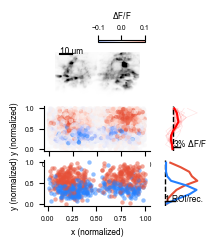

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(2,2.5), height_ratios=(1,1,1), width_ratios=(3,1))

## Visualize example fish anatomy stack
stack = D['stack'][0, :, :]
stack = stack[:, D['mask']['x0']:D['mask']['x1']][D['mask']['y0']:D['mask']['y1'],:] # crop
stack = np.rot90(np.flipud(stack)) # the way I wrote the microscope software is rotated flipped, so we need this
ax[0,0].imshow(stack, cmap='gray_r', vmin=np.percentile(stack,1), vmax=np.percentile(stack,99))

# show the scale bar (max magnification of the 2p microscope is 500 um)
px_per_um = 500 / D['zoom'] / D['stack'].shape[1]
ax[0,0].text(30, 10, '10 um')
ax[0,0].plot((30, 30+10/px_per_um),(10,10),'k-',lw=1.5)

## Population data
for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        # show all DS cells
        sc0 = ax[1, 0].scatter(D['norm_coords'][0], D['norm_coords'][1], c=D['early_mean_diff'], s=10, vmin=-0.1, vmax=0.1, cmap=cc.cm.CET_D9, alpha=0.5)
        # show memory cells
        for k in range(2):
            ind = D['mcell_inds'][k]
            ax[2, 0].scatter(D['norm_coords'][0][ind], D['norm_coords'][1][ind], color=cc.cm.CET_D9(1.0 - 1.0*k), s=10, alpha=0.5)
        
cb0 = plt.colorbar(sc0, ax=ax, shrink=0.3, location='top')
cb0.set_label('$\Delta$F/F')

## Show binned median tuning next to the scatter
ax[1, 1].plot(np.nanmedian(emd_on_x,axis=0), x_bin_cen, lw=1.5, color='red')
ax[2, 1].plot(np.sum(mcell_count_on_x[:,0,:],axis=0)/n_rec, x_bin_cen, lw=1.5, color=cc.cm.CET_D9(1.0))
ax[2, 1].plot(np.sum(mcell_count_on_x[:,1,:],axis=0)/n_rec, x_bin_cen, lw=1.5, color=cc.cm.CET_D9(0.0))
for y0 in emd_on_x:
    ax[1, 1].plot(y0, x_bin_cen, color='red', lw=0.5, alpha=0.1, zorder=-3)
ax[1, 1].plot((0,0),(0,1),'k--', zorder=-2)
ax[2, 1].plot((0,0),(0,1),'k--', zorder=-2)
ax[1, 1].plot((0.01, 0.04), (0.1, 0.1), 'k-')
ax[1, 1].text(0, 0.1, '3% $\Delta$F/F')
ax[2, 1].plot((0, 1), (0.1, 0.1), 'k-')
ax[2, 1].text(0, 0.1, '1 ROI/rec.')

# axis management
ax[0,0].axis('off')

for i in (1,2):
    ax[i,0].set_xlabel('x (normalized)')
    ax[i,0].set_ylabel('y (normalized)')
    
for k, axx in enumerate(ax[:,1]):
    axx.set_ylim([0,1])
    toggle_spines(axx, 0, 0, 0, 0)

toggle_spines(ax[1,0],0,1,0,1)
toggle_spines(ax[2,0],0,1,0,1)

plt.savefig('./svgs/Fig7CD.svg', format='svg')
plt.show()

### Fig. 7EFG (memory activity across conditions)

forward memory cells Forward resp  wave - vs + p=3.05e-04
forward memory cells Backward resp wave - vs + p=1.83e-04
forward memory cells (F - B) wave - vs + p=8.47e-01
backward memory cells Forward resp  wave - vs + p=6.10e-05
backward memory cells Backward resp wave - vs + p=6.10e-05
backward memory cells (F - B) wave - vs + p=3.30e-01


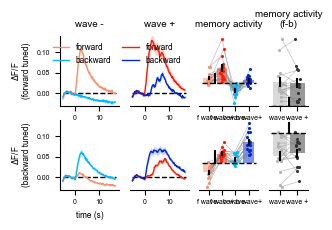

In [35]:
fig, ax = plt.subplots(2, 4, figsize=(3.2,2), width_ratios=(3,3,3,2))

labels = ('forward', 'backward')

cmaps = (cc.cm.CET_D11, cc.cm.CET_D8)
wave_cols = (cmaps[0](255),cmaps[1](255),cmaps[0](0),cmaps[1](0))


for i in range(2): # f/b cells
    for j in range(2): # wave -/+
        
        # time traces
        ax[i,j].plot((-5,17),(0,0),'k--',zorder=-3)
        ax[i,j].set_ylim([-0.03,0.14])
        for k in range(2): # f or b pulses
            # epochs are ordered training f/b, test f/b, wave f/b
            plot_mean_sem(ax[i,j], t_snip-5, mean_resps[:, i, 2+2*j+k, :], color=cmaps[j](255*(1-k)), label=labels[k])
        
    # bar plots
    praw = scatter_bar(late_resps[:, i, (2,4,3,5)].T, connect=True, color=wave_cols, ax=ax[i,2], condnames=('f wave-','f wave+','b wave-','b wave+'))
    pdiff = scatter_bar(late_resps[:, i, (2,4)].T-late_resps[:, i, (3,5)].T, connect=True, color=((0.7,0.7,0.7),(0.2,0.2,0.2)), ax=ax[i,3], condnames=('wave -','wave +'))
    
    # print stats
    print(labels[i], 'memory cells Forward resp  wave - vs + p={:0.2e}'.format(praw[0,1]))
    print(labels[i], 'memory cells Backward resp wave - vs + p={:0.2e}'.format(praw[2,3]))
    print(labels[i], 'memory cells (F - B) wave - vs + p={:0.2e}'.format(pdiff[0,1]))
    
    # scale bars
    ax[i,2].plot((0.5,0.5),(0,0.02),'k-',lw=1.5) # 2% dF/F
    ax[i,3].plot((0.5,0.5),(0,0.01),'k-',lw=1.5) # 1% dF/F
    ax[i,2].plot((-0.5,3.5),(0,0),'k--') # 0 dF/F
    ax[i,3].plot((-0.5,1.5),(0,0),'k--') # 0 dF/F
    

# axis management

ax[0,0].legend()
ax[0,1].legend()

ax[0,0].set_title('wave -')
ax[0,1].set_title('wave +')
ax[0,2].set_title('memory activity')
ax[0,3].set_title('memory activity\n(f-b)')

ax[1,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('$\Delta$F/F\n(forward tuned)')
ax[1,0].set_ylabel('$\Delta$F/F\n(backward tuned)')

for axx in ax:
    toggle_spines(axx[0],0,1,0,1)
    toggle_spines(axx[1],0,1,0,0)
    toggle_spines(axx[2],0,1,0,0)
    toggle_spines(axx[3],0,1,0,0)
        
plt.savefig('./svgs/Fig7EFG.svg', format='svg')
plt.show()